# Project Introduction

This challenge is a Kaggle competition using the "Natural Language Processing with Disaster Tweets" data set. The objective of this challenge is to analyze the data and build a machine learning model predicts whether the tweet in questions are about real disasters or not. Therefore this is a binary classificaiton task and requires NLP or natural language processing techniques. 

NLP is a technique that allows computers to recongnize and understand and geneate text using machine learning models. Some applications of NLP include spam filters, chat generation, translation applications. They use tehcniques like tokenization and use alogorithms to identify patterns, grammar, and context of text. 

In [27]:
import string
import re
import random
# EDA 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, Bidirectional

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
# evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# nltk.data.path.insert(0, r'C:\Users\9094y\AppData\Roaming\nltk_data')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\9094y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\9094y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\9094y\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\9094y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
np.random.seed(42)
random.seed(42)

# Data

Data used is in this challenge is publicly available on Kaggle: https://www.kaggle.com/c/nlp-getting-started/data

In [4]:
# Load the dataset
train_df = pd.read_csv('./inputs/train.csv')
test_df = pd.read_csv('./inputs/test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Based on the initial analysis, we can observe that there are missing values for keyword and location. This makes sense since not every post on X (Twitter) is required to contain the location tag or keywords. We will further check to see the number of missing values to determine whether the feature will be included in the training of the model.

In [5]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Data Overview

- The training data set contains 7613 tweets and each row in the dataset contains the following information:

1. id
2. keyword
3. locaiton
4. text
5. target: 0 = Not a real disaster, 1= Real disaster 

# EDA

We will first begin by performing basic EDA such as finding missing values, visualization, and determing the distribution of the target variable. 

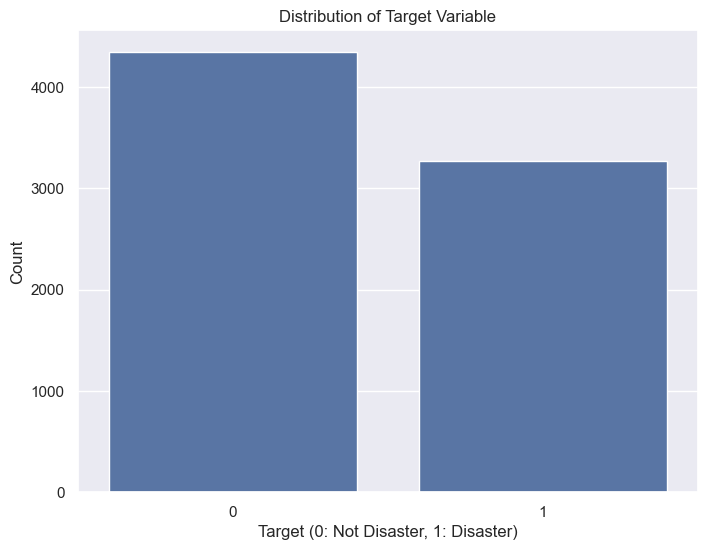

In [7]:
### Distribution of target variable

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.show()

In [8]:
### Check the number of missing values 

print("Missing values in training data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())

Missing values in training data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test data:
id             0
keyword       26
location    1105
text           0
dtype: int64


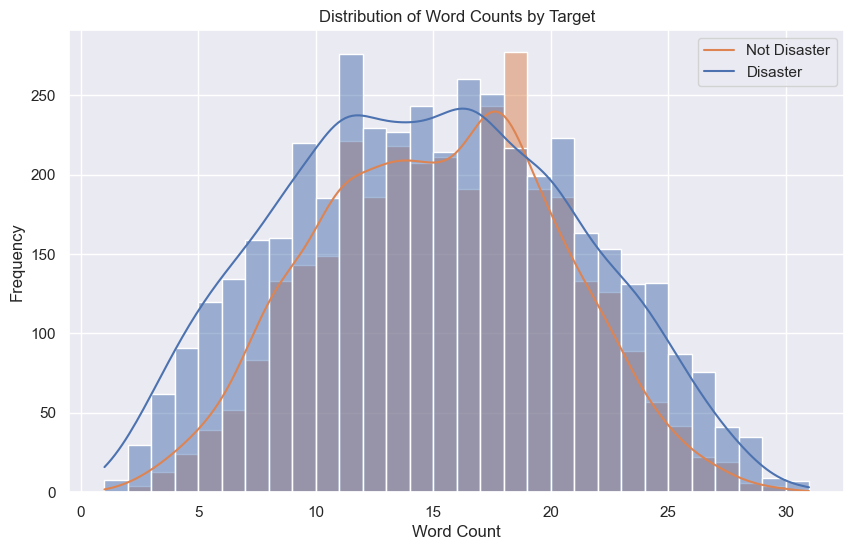

In [9]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='word_count', hue='target', bins=30, kde=True)
plt.title('Distribution of Word Counts by Target')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(['Not Disaster', 'Disaster'])
plt.show()

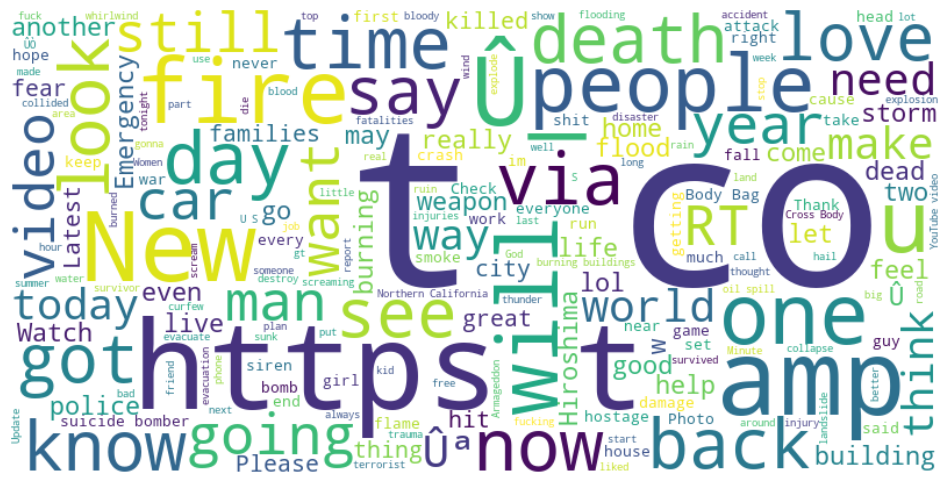

In [10]:
### Word cloud
tweets = ' '.join(train_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(tweets)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Analysis of EDA

Based on the above EDA, we have observed a few things

1. Missing values: there are a lot of missing values in the location which we will have to handle
2. Class distribution: it is relatively balanced
3. Word Usage: there are a lot of words present in the word cloud that provides no additional information to the context of the tweet. These include words like co, will, u, and links like https, and etc. 



# Preprocessing and Data Cleaning

In [14]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (keeping the text)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into text
    text = ' '.join(tokens)
    
    return text

# Apply preprocessing to train and test data
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)


In [16]:
train_df.head()

,id,keyword,location,text,target,word_count,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,got sent photo ruby alaska smoke wildfire pour...


In [18]:
comparison_df = pd.DataFrame({
    'Original Text': train_df['text'].head(5),
    'Cleaned Text': train_df['cleaned_text'].head(5)
})

comparison_df

,Original Text,Cleaned Text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


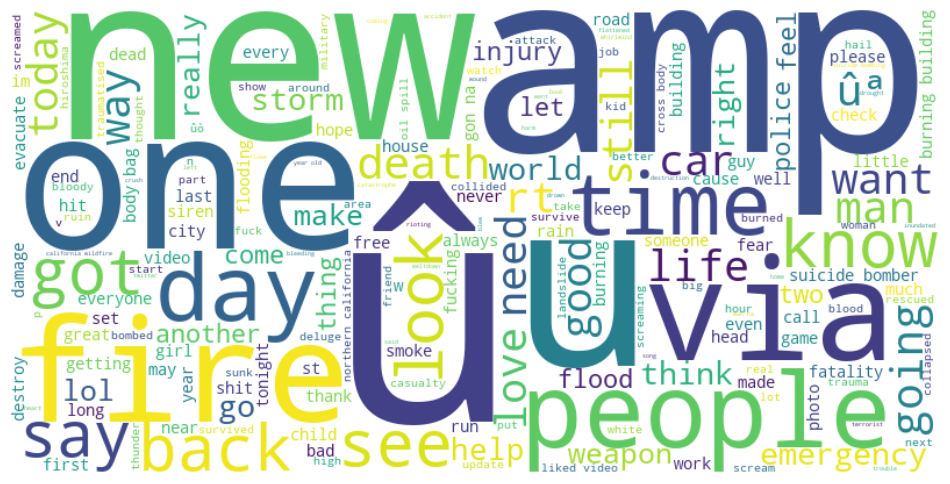

In [20]:
### Wordcloud on cleaned text 
clean_tweets = ' '.join(train_df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(clean_tweets)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Embedding

1. Feature Extraction:
   - Use TF-IDF vectorization to convert text data to numerical features
   - Reasons for choosing TF-IDF:
     a) It accounts for word frequency while downweighting common words
     b) Works well with NMF for topic modeling
     c) Better than simple bag-of-words for capturing semantic importance
     
TF-IDF gives higher weights to terms that appear frequently in a specific document but rarely in the overall corpus, making it particularly useful for identifying distinctive terms in text classification tasks.

Unlike word embeddings (such as GloVe or Word2Vec) which preserve semantic relationships between words, TF-IDF creates a sparse matrix representation focusing on term importance. It's often effective for tasks where the presence of specific words is highly discriminative.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000, 
                                  min_df=5,
                                  max_df=0.8,
                                  ngram_range=(1, 2),
                                  sublinear_tf=True)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

# Target variable
y_train = train_df['target'].values

### Split the training data into training and validation set

In [22]:
from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42
)

In [23]:
# feature_names = tfidf_vectorizer.get_feature_names_out()
# idf_scores = tfidf_vectorizer.idf_
# feature_idf = dict(zip(feature_names, idf_scores))

# # Display top 20 features with highest IDF (rarest, most distinctive terms)
# top_features = sorted(feature_idf.items(), key=lambda x: x[1], reverse=True)[:20]
# print("\nTop 20 most distinctive terms (highest IDF):")
# for feature, score in top_features:
#     print(f"{feature}: {score:.4f}")

# # Display top 20 features with lowest IDF (most common terms)
# bottom_features = sorted(feature_idf.items(), key=lambda x: x[1])[:20]
# print("\nTop 20 most common terms (lowest IDF):")
# for feature, score in bottom_features:
#     print(f"{feature}: {score:.4f}")


In [26]:
def sparse_to_tensor(sparse_matrix):
    dense_matrix = sparse_matrix.todense()
    return tf.convert_to_tensor(dense_matrix, dtype=tf.float32)

# Convert training and validation sets to tensors
X_train_tensor = sparse_to_tensor(X_train_final)
X_val_tensor = sparse_to_tensor(X_val)
X_test_tensor = sparse_to_tensor(X_test_tfidf)

print(f"Training tensor shape: {X_train_tensor.shape}")
print(f"Validation tensor shape: {X_val_tensor.shape}")
print(f"Test tensor shape: {X_test_tensor.shape}")

Training tensor shape: (6090, 3434)
Validation tensor shape: (1523, 3434)
Test tensor shape: (3263, 3434)


# Model

c:\Users\9094y\workspace\nlp\.venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 3434, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5667 - loss: 0.6884 - val_accuracy: 0.5739 - val_loss: 0.6832
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.5727 - loss: 0.6826 - val_accuracy: 0.5739 - val_loss: 0.6829
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5718 - loss: 0.6845 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.5737 - loss: 0.6830 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5653 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6826


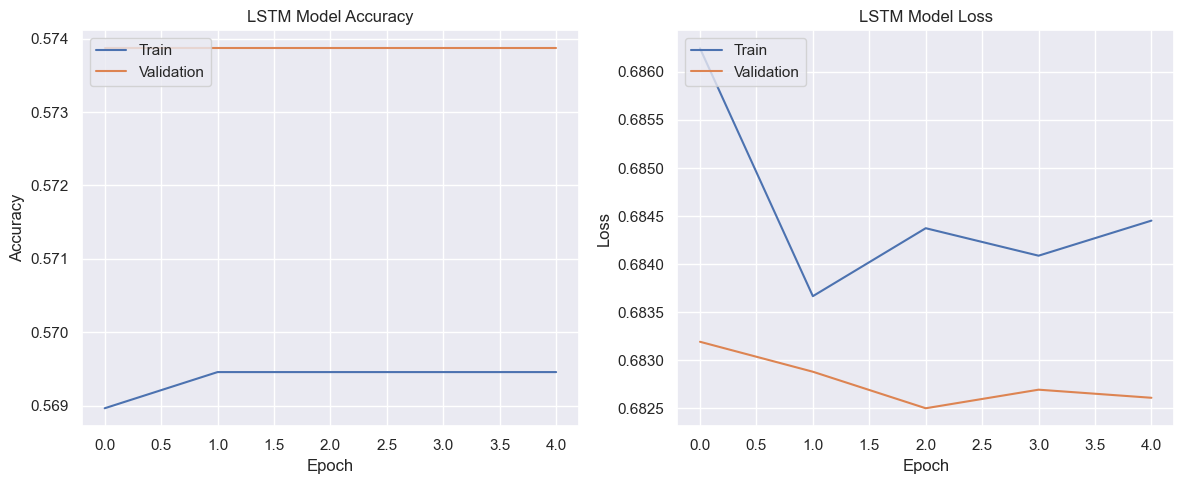

In [28]:
lstm_model = Sequential()
lstm_model.add(Reshape((X_train_tensor.shape[1], 1), input_shape=(X_train_tensor.shape[1],)))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Display model summary
lstm_model.summary()

# Train the model
lstm_history = lstm_model.fit(
    X_train_tensor, y_train_final,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_tensor, y_val),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
### Evaluation of model

y_pred_lstm = (lstm_model.predict(X_val_tensor) > 0.5).astype(int).flatten()
lstm_accuracy = accuracy_score(y_val, y_pred_lstm)
print("LSTM Model Evaluation:")
print(f"Validation Accuracy: {lstm_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lstm))

### CNN Model

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Build a CNN model for TF-IDF features
cnn_model = Sequential()
cnn_model.add(Reshape((X_train_tensor.shape[1], 1), input_shape=(X_train_tensor.shape[1],)))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Conv1D(32, 3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

# Display model summary
cnn_model.summary()

# Train the model
cnn_history = cnn_model.fit(
    X_train_tensor, y_train_final,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_tensor, y_val),
    verbose=1
)


y_pred_cnn = (cnn_model.predict(X_val_tensor) > 0.5).astype(int).flatten()
cnn_accuracy = accuracy_score(y_val, y_pred_cnn)
print("CNN Model Evaluation:")
print(f"Validation Accuracy: {cnn_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_cnn))

# Result and Analysis

Based on the above analysis and results, we can conlcude that the 

- LSTM model achieved better score over the CNN model
- Word Embeddings: used TFID 


### Submission

In [29]:
test_predictions = (best_model.predict(X_test_tensor) > 0.5).astype(int).flatten()

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created.")

NameError: name 'best_model' is not defined

# Conclusion

Through this project, we have laernt the basics of NLPs. We were able to develop multiple models that classify tweets as something that contains disasters or does not. 

We have learnt the importance of preprocessing, the different type of word embedding methods and the potential impact it has on the model, some advanced RNN techniques like LSTM.

In the future, we can explore more advanced preprocessing, using different Word embedding methods, more data augmentation for a much more generalized model, and etc. 